In [16]:
import os
import keras
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras import backend as K
import keras.utils as image
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import pickle
import sklearn


In [2]:
# This sets a common size for all the figures we will draw.
plt.rcParams['figure.figsize'] = [10, 7]


In [11]:
#UTILS FUNCTIONS
def get_mean_std_per_batch(df, H=320, W=320):
    sample_data = []
    IMAGE_DIR = 'data/nih_new/images-small/'
    
    for idx, img in enumerate(df.sample(100)["Image"].values):
        path = IMAGE_DIR + img
        sample_data.append(np.array(image.load_img(path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std    

def load_image_normalize(path, mean, std, H=320, W=320):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, df, preprocess=True, H = 320, W = 320):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(df, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x

def compute_gradcam(model, img, data_dir, df, labels, selected_labels, layer_name='bn'):
    img_path = data_dir + img
    preprocessed_input = load_image(img_path, df)
    predictions = model.predict(preprocessed_input)
    print("Ground Truth: ", ", ".join(np.take(labels, np.nonzero(df[df["Image"] == img][labels].values[0]))[0]))

    plt.figure(figsize=(15, 10))
    plt.subplot(151)
    plt.title("Original")
    plt.axis('off')
    plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
    
    j = 1
    for i in range(len(labels)):
        if labels[i] in selected_labels:
            print("Generating gradcam for class %s (p=%2.2f)" % (labels[i], round(predictions[0][i], 3)))
            gradcam = grad_cam(model, preprocessed_input, i, layer_name)
            plt.subplot(151 + j)
            plt.title(labels[i] + ": " + str(round(predictions[0][i], 3)))
            plt.axis('off')
            plt.imshow(load_image(img_path, df, preprocess=False), cmap='gray')
            plt.imshow(gradcam, cmap='jet', alpha=min(0.5, predictions[0][i]))
            j +=1

def cindex(y_true, scores):
    return lifelines.utils.concordance_index(y_true, scores)

# LOAD MODEL FROM C1M2
def load_and_pickle_model():
    labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

    train_df = pd.read_csv("data/nih_new/train-small.csv")
    valid_df = pd.read_csv("data/nih_new/valid-small.csv")
    test_df = pd.read_csv("data/nih_new/test.csv")

    class_pos = train_df.loc[:, labels].sum(axis=0)
    class_neg = len(train_df) - class_pos
    class_total = class_pos + class_neg

    pos_weights = class_pos / class_total
    neg_weights = class_neg / class_total
    
    print("Got loss weights")
    
    # create the base pre-trained model
    base_model = DenseNet121(weights='pretrained_model/densenet.hdf5', include_top=False)
    print("Loaded DenseNet")
    
    # add : a + pos_weights +  global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    
    # and a logistic layer
    predictions = Dense(len(labels), activation="sigmoid")(x)
    print("Added layers")

    model = Model(inputs=base_model.input, outputs=predictions)

    def get_weighted_loss(neg_weights, pos_weights, epsilon=1e-7):
        def weighted_loss(y_true, y_pred):
            # L(X, y) = −w * y log p(Y = 1|X) − w *  (1 − y) log p(Y = 0|X)
            # from https://arxiv.org/pdf/1711.05225.pdf
            loss = 0
            for i in range(len(neg_weights)):
                loss -= (neg_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon) + 
                         pos_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            
            loss = K.sum(loss)
            return loss
        return weighted_loss

    # Save the weighted loss
    weighted_loss = get_weighted_loss(neg_weights, pos_weights)
    
    model.compile(optimizer='adam', loss=weighted_loss)
    print("Compiled Model")

    model.load_weights("data/nih_new/pretrained_model.h5")
    print("Loaded Weights")

    # Many ways to save and retrieve a model (pickle, JSON and weight and inbuild keras function
    # We will use the JSON method

    # serialize model to JSON
    model_json = model.to_json()
    with open("saved_model/cdc_model.json", "w") as json_file:
        json_file.write(model_json)
    
    print("Saved Model JSON")
    
    # serialize weights to HDF5
    model.save_weights("saved_model/cdc_model_weights.h5")
    
    print("Saved Model Weights")
    
    # Pickle the mean and the std values too so that they can be used during
    # to normalize the image before predict
    df = pd.read_csv('data/nih_new/train-small.csv')    
    mean, std = get_mean_std_per_batch(df, H=320, W=320)
    cdc_variables = dict(saved_mean=mean, saved_std=std)

    with open('saved_model/cdc_mean_std.pkl', 'wb') as f1:
        pickle.dump(cdc_variables, f1)
    
    with open('saved_model/pos_weights.pkl', 'wb') as f2:
        pickle.dump(pos_weights, f2)

    with open('saved_model/neg_weights.pkl', 'wb') as f3:
        pickle.dump(neg_weights, f3)

    print("Pickle CDC variables")
    
    return model
    

In [12]:
model = load_and_pickle_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights
Saved Model JSON
Saved Model Weights
Pickle CDC variables


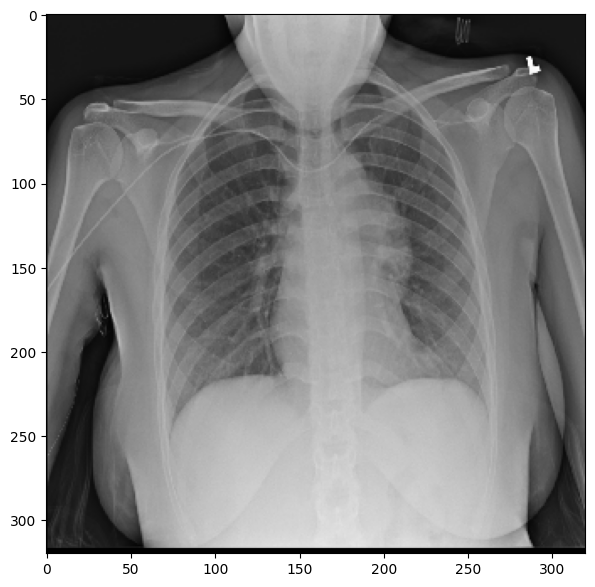

In [13]:
IMAGE_DIR = 'data/nih_new/images-small/'
df = pd.read_csv('data/nih_new/train-small.csv')
im_path = IMAGE_DIR + '00025288_001.png' 
x = load_image(im_path, df, preprocess=False)
plt.imshow(x, cmap = 'gray')
plt.show()


In [14]:
mean, std = get_mean_std_per_batch(df)

1/1 [==============================] - 4s 4s/step


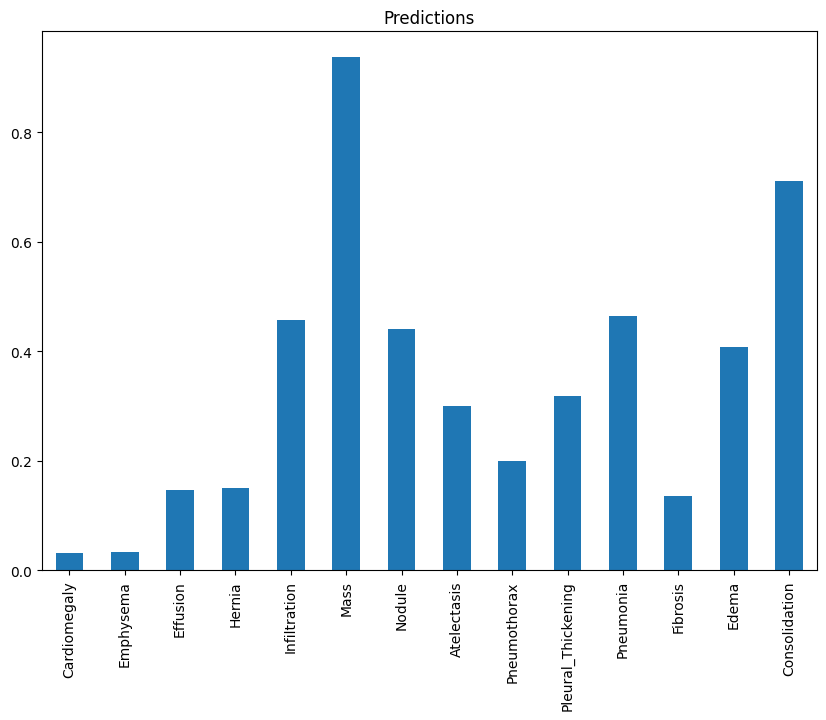

In [15]:
labels = ['Cardiomegaly', 'Emphysema', 'Effusion', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Atelectasis',
              'Pneumothorax', 'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema', 'Consolidation']

processed_image = load_image_normalize(im_path, mean, std)
preds = model.predict(processed_image)
pred_df = pd.DataFrame(preds, columns = labels)
pred_df.loc[0, :].plot.bar()
plt.title("Predictions")
plt.show()